This notebook demonstrates how to fine-tune a Persian GPT-2 model ([HooshvareLab/gpt2-fa](https://huggingface.co/HooshvareLab/gpt2-fa)) for conditional poetry generation ([HooshvareLab/gpt2-fa-poetry](https://huggingface.co/HooshvareLab/gpt2-fa-poetry)). HooshvareLab/gpt2-fa, a Persian-optimized version of GPT-2 developed by HooshvareLab.

The model learns to generate poetry in the style of specific Persian poets based on a prompt containing the poet's name.

In [1]:
!pip install -qU transformers
!pip install -qU hazm

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 892.6/892.6 kB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 53.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 60.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 32.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.3/243.3 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 16.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.24.3 which is incompatible.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but y

In [1]:
import hazm


normalizer = hazm.Normalizer(persian_numbers=False)

def normalize_input(text):
    text = normalizer.normalize(text)
    return text

In [2]:
# Load dataset
!git clone https://github.com/aghasemi/ChronologicalPersianPoetryDataset.git poems

Cloning into 'poems'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 39 (delta 2), reused 0 (delta 0), pack-reused 33 (from 1)
Receiving objects: 100% (39/39), 34.27 MiB | 8.73 MiB/s, done.
Resolving deltas: 100% (19/19), done.
Updating files: 100% (8/8), done.


In [3]:
import json
import os
import glob

import numpy as np
import pandas as pd

from tqdm import tqdm

In [ ]:
df = pd.read_csv("/content/poems/poems.tsv", sep="\t")

# Depends on you
df["poem"] = df["poem"].apply(lambda t: normalize_input(t))

df["text"] = df["poet"] + "<|startoftext|>" + df["poem"].apply(lambda t: t.replace("    ", "<sep>").replace("\t", "<sep>"))
df = df.dropna()
df = df.reset_index(drop=True)
df.head()

In [ ]:
poets = list(df["poet"].unique())

In [ ]:
idx = np.random.randint(0, len(df))
print(idx)
print(df.iloc[idx]["poet"])
print(df.iloc[idx]["poem"])
print(df.iloc[idx]["text"])

In [ ]:
import pandas as pd
import numpy as np

from pathlib import Path

import torch
from transformers import AutoTokenizer, AutoConfig, AutoModelWithLMHead
from transformers import AutoTokenizer, GPT2LMHeadModel, GPT2Config

from IPython import display

In [ ]:
model_name_or_path = "HooshvareLab/gpt2-fa"

tokenizer = AutoTokenizer.from_pretrained(
    model_name_or_path,
    bos_token='<s>',
    eos_token='</s>',
    pad_token='<pad>',
    unk_token='<unk>'
)
tokenizer.add_special_tokens({
    "bos_token": '</s>',
    "eos_token": '</s>',
    "pad_token": '<pad>',
    "unk_token": '<unk>'
})

config = AutoConfig.from_pretrained(
    model_name_or_path,
    bos_token_id=tokenizer("<s>")["input_ids"][0],
    eos_token_id=tokenizer("</s>")["input_ids"][0],
    pad_token_id=tokenizer("<pad>")["input_ids"][0],
    unk_token_id=tokenizer("<unk>")["input_ids"][0],
)

tokenizer.save_pretrained("/content/gpt2/")
config.save_pretrained("/content/gpt2/")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/728 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/808 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/875k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.75M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/14.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/104 [00:00<?, ?B/s]

In [ ]:
!wget "https://huggingface.co/HooshvareLab/gpt2-fa/resolve/main/pytorch_model.bin" -P /content/gpt2/
!wget "https://huggingface.co/HooshvareLab/gpt2-fa/resolve/main/tokenizer.json" -P /content/gpt2/

--2025-05-17 19:49:57--  https://huggingface.co/HooshvareLab/gpt2-fa/resolve/main/pytorch_model.bin
Resolving huggingface.co (huggingface.co)... 18.164.174.55, 18.164.174.23, 18.164.174.17, ...
Connecting to huggingface.co (huggingface.co)|18.164.174.55|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.hf.co/HooshvareLab/gpt2-fa/46b0b806c740a0f0a9f056f5574c5fa896166fe844945fd3c849bf34365e5060?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27pytorch_model.bin%3B+filename%3D%22pytorch_model.bin%22%3B&response-content-type=application%2Foctet-stream&Expires=1747514998&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTc0NzUxNDk5OH19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5oZi5jby9Ib29zaHZhcmVMYWIvZ3B0Mi1mYS80NmIwYjgwNmM3NDBhMGYwYTlmMDU2ZjU1NzRjNWZhODk2MTY2ZmU4NDQ5NDVmZDNjODQ5YmYzNDM2NWU1MDYwP3Jlc3BvbnNlLWNvbnRlbnQtZGlzcG9zaXRpb249KiZyZXNwb25zZS1jb250ZW50LXR5cGU9KiJ9XX0_&Signature=shcYW%7EN2-p2F1X

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(
    "/content/gpt2",
    bos_token='<s>',
    eos_token='</s>',
    pad_token='<pad>'
)

print(tokenizer.encode("سلام بر شما"))
print(tokenizer.encode("<s>"))
print(tokenizer.encode("</s>"))
print(tokenizer.encode("<pad>"))
print(tokenizer.encode("<|startoftext|>"))
print(tokenizer.encode("<sep>"))

[8906, 327, 512]
[0]
[2]
[1]
[6]
[9]


In [ ]:
texts = df["text"].values.tolist()

print(len(texts))

54524


In [ ]:
df[df['poet']=='حافظ']

,poet,century,poem,text
24358,حافظ,8,جز نقش تو در نظر نیامد ما را جز کوی تو رهگذ...,حافظ<|startoftext|>جز نقش تو در نظر نیامد ما ر...
24359,حافظ,8,بر گیر شراب طرب‌انگیز و بیا پنهان ز رقیب سف...,حافظ<|startoftext|>بر گیر شراب طرب‌انگیز و بیا...
24360,حافظ,8,گفتم که لبت، گفت لبم آب حیات گفتم دهنت، گفت...,حافظ<|startoftext|>گفتم که لبت، گفت لبم آب حیا...
24361,حافظ,8,ماهی که قدش به سرو می‌ماند راست آیینه به دس...,حافظ<|startoftext|>ماهی که قدش به سرو می‌ماند ...
24362,حافظ,8,من باکمر تو در میان کردم دست پنداشتمش که در...,حافظ<|startoftext|>من باکمر تو در میان کردم دس...
...,...,...,...,...
27427,حافظ,8,به جد و جهد چو کاری نمی رود از پیش به کردگا...,حافظ<|startoftext|>به جد و جهد چو کاری نمی رود...
27428,حافظ,8,رهروان را عشق بس باشد دلیل آب چشم اندر رهش ...,حافظ<|startoftext|>رهروان را عشق بس باشد دلیل<...
27429,حافظ,8,روز عید است و من امروز در آن تدبیرم که دهم ...,حافظ<|startoftext|>روز عید است و من امروز در آ...
27430,حافظ,8,ای در چمن خوبی رویت چو گل خودرو چین شکن زلف...,حافظ<|startoftext|>ای در چمن خوبی رویت چو گل خ...


In [ ]:
texts[24358]

'حافظ<|startoftext|>جز نقش تو در نظر نیامد ما را<sep>جز کوی تو رهگذر نیامد ما را<sep>خواب ارچه خوش آمد همه را در عهدت<sep>حقا که به چشم در نیامد ما را'

In [ ]:
max_seq = 256

In [ ]:
from torch.utils.data import Dataset
import torch

torch.manual_seed(42)

class MTGDataset(Dataset):
    def __init__(self, txt_list, tokenizer, max_length=1024):
        self.tokenizer = tokenizer
        self.data = []

        for txt in txt_list:
            encodings_dict = tokenizer(
                '<s>' + txt + '</s>',
                truncation=True,
                max_length=max_length,
                padding="max_length",
                return_tensors="pt"
            )

            self.data.append({
                "input_ids": encodings_dict["input_ids"].squeeze(0),  # Remove batch dim
                "attention_mask": encodings_dict["attention_mask"].squeeze(0),
                "labels": encodings_dict["input_ids"].squeeze(0)  # Labels are the same as input
            })

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]  # Returns a dict (Trainer requires dict format)


In [ ]:
from torch.utils.data import random_split

dataset = MTGDataset(texts, tokenizer, max_length=max_seq)

# Split into training and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

f'There are {len(train_dataset)} samples for training, and {len(val_dataset)} samples for validation testing'

'There are 49071 samples for training, and 5453 samples for validation testing'

---

In [ ]:
index = 1053
print(train_dataset[index]['input_ids'][:100])
print(tokenizer.decode(train_dataset[index]['input_ids'][:100]))

tensor([    0, 40719,     6,   476,  1061,  5634,   953,   991,   403,   312,
         1352,  9540,     9, 29930,   287,   421,  9268, 11042,  3645,   327,
         4141,   293,  7323,     9,  8101,   303,   798, 18085,   390,   326,
         2728, 18369,     9,  2076,   817,  1013,   484,  1733,  1801,   303,
          798, 18085,     9,   316, 24744,   571,   330, 39148,   546,   303,
         3590,  6306,   742,     9,   278,  5748,  8503,   395,   312,   451,
         2167,   440,  8768,   751,     9,  2076, 11392,   960,   318,  3645,
          326,  1323, 26680,  2511, 15987,     9,   458,  3735,   314,  4446,
        20927,   310,   285, 19581,  3645,  7935,     9,  2802,   773,  3982,
         8776,   457,   293, 14162,  7607,   486,   451,     9,   589,   747])
<s>حافظ<|startoftext|>افسر سلطان گل پیدا شد از طرف چمن<sep>مقدمش یا رب مبارک باد بر سرو و سمن<sep>خوش به جای خویشتن بود این نشست خسروی<sep>تا نشیند هر کسی اکنون به جای خویشتن<sep>خاتم جم را بشارت ده به حسن خاتمت<sep>کاس

#Training model using huggingface Trainer API

---



In [ ]:
import random
from transformers import GPT2LMHeadModel, GPT2Config
import numpy as np

# Loading the model configuration and setting it to the GPT2 standard settings.
configuration = GPT2Config.from_pretrained('./gpt2', output_hidden_states=False)

# Create the instance of the model and set the token size embedding length
model = GPT2LMHeadModel.from_pretrained("./gpt2", config=configuration)
model.resize_token_embeddings(len(tokenizer))

# Tell pytorch to run this model on the GPU.
device = torch.device("cuda")
model.cuda()

# This step is optional but will enable reproducible runs.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
import torch
import random
import time
import datetime
from transformers import Trainer, TrainingArguments

epochs = 3 # or specify steps

# Function to format time
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

# # Custom function for evaluation metrics (returns only loss here)
# def compute_metrics(eval_pred):
#     logits, labels = eval_pred
#     loss_fct = torch.nn.CrossEntropyLoss()
#     loss = loss_fct(torch.tensor(logits), torch.tensor(labels))
#     return {"validation_loss": loss.item()}

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="steps",  # Evaluate at the end of each epoch
    save_strategy="steps",
    save_steps=2000,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=epochs,
    logging_dir="./logs",
    logging_steps=2000,
    save_total_limit=3,           # Keep only last 3 checkpoints
    load_best_model_at_end=True,
    report_to="none",             # Avoid sending logs to external trackers
)

# Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    # compute_metrics=compute_metrics
)

# Train the model
trainer.train()

# Evaluate
trainer.evaluate()


<ipython-input-31-e1a028fc2a58>:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Step,Training Loss,Validation Loss
2000,2.935400,2.728100


In [ ]:
import re


def generator(model, poet, max_length=128, num_return_sequences=3):
    model.eval()
    prompt = f"<s>{poet}<|startoftext|>"
    print(prompt)

    generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
    generated = generated.to(device)

    decoded_outputs = model.generate(
        generated,
        do_sample=True,
        top_k=50,
        max_length=max_length,
        top_p=0.95,
        num_return_sequences=num_return_sequences
    )


    outputs = []
    for i, output in enumerate(decoded_outputs):
        o = tokenizer.decode(output, skip_special_tokens=False)
        o = o.replace("<s>", "").replace("</s>", "")
        outputs.append(o)



    display.display(display.HTML("""
    <style>
    @import url("https://cdn.jsdelivr.net/gh/rastikerdar/vazir-font@v27.1.0/dist/font-face.css");

    table.xxx {
        margin-right: 15px;
        font-size: 14px;
        direction: rtl !important;
        width: 100%;
        display: flex;
    }
    table.xxx td {
        min-width: 300px !important;
        direction: rtl !important;
        text-align: right !important;
        font-family: "Vazir" !important;
    }
    </style>
    """.strip()))


    df = pd.DataFrame(outputs, columns=["generated"])
    df["generated"] = df["generated"].apply(lambda t: re.sub("\n+", "\n", t.replace("<sep>", "\n")))
    df["generated"] = df["generated"].apply(lambda t: "<p>" + t.replace("\n", "<br/>").replace("<|startoftext|>", "<br/>").strip() + "</p>")


    setup = {
        'border': 2,
        'show_dimensions': True,
        'escape': False,
        'justify': 'right',
        'classes': 'xxx'
    }
    display.display(display.HTML(df.to_html(**setup)))

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer

checkpoint = 4000  # after 4000 iteration
# Load the best trained model
model_path = "./results/checkpoint-4000"  # or any directory where the best model is saved
hf_model = AutoModelForCausalLM.from_pretrained(model_path)
hf_tokenizer = AutoTokenizer.from_pretrained(model_path)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
hf_model.to(device)
hf_model.eval()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(42001, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=42001, bias=False)
)

In [ ]:
generator(hf_model, 'حافظ', num_return_sequences=2)

<s>حافظ<|startoftext|>


,generated
0,حافظای بی‌تو که در عالم افکنی چو حبابیا رب ای مرغزار و مرغزار و مرغزاراز پی خلق جهان را بشکافبر تو ز چه رو دست می‌بندی چو حبابدیوانه شو که نه من خود را از خود جدا می‌کنمدر ره تو چو بر تو هم بی‌اختیار می‌کنمای دل چو در کار تویی و چو تو نیز در کارتا به کی این راه به مقصد می‌کنی چو حباباین غزل غزل اگر آن روز به تو رسید دلبهر آن که به تو این جا نیز می‌کنی چو حباب
1,حافظبگذر از لب یار که جان من استمن دل و جان به من که جان من استبگذر ز خود آن دل که با دلم نشستدلم به من به جان که جان من استعرفی به زلف تو نتوان کرد دلگر نه در این کار که جان من استمن ز وصل تو جان به جان و جان می‌دهمکز دل و جان به جان جان من استمطلب به کام دل که در دست استخوشا که تا زنده‌ام از دل دوستتا به کی بر این خاکدان جان من است


In [ ]:
generator(hf_model, 'سهراب سپهری', num_return_sequences=2)

<s>سهراب سپهری<|startoftext|>


,generated
0,سهراب سپهریدر این دشت پرآشوب، بیقراری ها می کنند، و به تاریکی های خود میپرند. با این که این بیابان ها را به یکدیگر آورده است، اما اینجا، جاییست که از سادگی های دیگر لذت می برد. ، برای من هر شبی که می رفتم و به خواب رفته ام، و برای من بی خواب، و اگر می خوردم، به جایی، که تنها، مرا از برای خود می برند، و من بی خواب به تنهایی هستم. در این خانه اما، نمی توانم گذشت، و من بی خیال. اگر چه، اما، می دانم که چگونه در این مکان بیگانه،
1,سهراب سپهریدر آن پنجره که از تو بیرون نیستپرتو را در سر ما و بیرون نیستآه، که می سوزد بر من، ای خوش، که در دل شببا من ای خوش نشین، ای بی باک، ای خوش نشین،در این میان، گر چه غم، غم از دل، آیداز تو، می سوزد خون من، به امید دل، که در شب،گل می نوش، ای خوش می نوش، ای خوش خوش بیا، ای خوشگل می می بارد از دست و گر بر خاک می زنندبر سر ما، به هر گلی که


# Train  without Trainer API

In [ ]:
# load agian

import random
from transformers import GPT2LMHeadModel, GPT2Config
import numpy as np

# Loading the model configuration and setting it to the GPT2 standard settings.
configuration = GPT2Config.from_pretrained('./gpt2', output_hidden_states=False)

# Create the instance of the model and set the token size embedding length
model = GPT2LMHeadModel.from_pretrained("./gpt2", config=configuration)
model.resize_token_embeddings(len(tokenizer))

# Tell pytorch to run this model on the GPU.
device = torch.device("cuda")
model.cuda()

# This step is optional but will enable reproducible runs.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

train_dataloader = DataLoader(
    train_dataset,
    sampler=RandomSampler(train_dataset),
    batch_size=8
)

validation_dataloader = DataLoader(
    val_dataset,
    sampler=SequentialSampler(val_dataset),
    batch_size=8
)

In [ ]:
epochs = 3
warmup_steps = 1e2
sample_every = 1000

In [ ]:
from transformers import AdamW

# AdamW is a class from the huggingface library, it is the optimizer we will be using, and we will only be instantiating it with the default parameters.
optimizer = AdamW(
    model.parameters(),
    lr=5e-4,
    eps=1e-8
)

In [ ]:
from transformers import get_linear_schedule_with_warmup

"""
Total training steps is the number of data points, times the number of epochs.
Essentially, epochs are training cycles, how many times each point will be seen by the model.
"""

total_steps = len(train_dataloader) * epochs

"""
We can set a variable learning rate which will help scan larger areas of the
problem space at higher LR earlier, then fine tune to find the exact model minima
at lower LR later in training.
"""
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps)


---

In [ ]:
import random
import time
import datetime
from tqdm import tqdm


def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))


total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in tqdm(range(0, epochs), position=0):

    print(f'Beginning epoch {epoch_i + 1} of {epochs}')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in tqdm(enumerate(train_dataloader), total=len(train_dataloader), position=0):

        b_input_ids = batch['input_ids'].to(device)
        b_labels = batch['input_ids'].to(device)
        b_masks = batch['attention_mask'].to(device)

        model.zero_grad()

        outputs = model(b_input_ids, labels=b_labels, attention_mask=b_masks, token_type_ids=None)

        loss = outputs[0]

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every 1000 batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print()
            print(f'Batch {step} of {len(train_dataloader)}. Loss:{batch_loss}. Time:{elapsed}')

            model.eval()

            sample_poet = poets[np.random.randint(0, len(poets))]
            sample_input = f"<s>{sample_poet}<|startoftext|>"
            sample_input_ids = torch.tensor(tokenizer([sample_input])["input_ids"])
            sample_input_ids = sample_input_ids.to(device)

            sample_outputs = model.generate(
                input_ids=sample_input_ids,
                # bos_token_id=random.randint(1, len(tokenizer.get_vocab())),
                do_sample=True,
                top_k=50,
                max_length=50,
                top_p=0.95,
                num_return_sequences=1
            )
            for i, sample_output in enumerate(sample_outputs):
                gen_sample_output = tokenizer.decode(sample_output, skip_special_tokens=False)
                gen_sample_output = gen_sample_output.replace("<|startoftext|>", "\n")
                gen_sample_output = gen_sample_output.replace("<s>", "")
                gen_sample_output = gen_sample_output.replace("</s>", "")
                gen_sample_output = gen_sample_output.replace("<sep>", "\n")

                print(f'Example output: {gen_sample_output}')

            model.train()

        loss.backward()
        optimizer.step()
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print()
    print(f'Average Training Loss: {avg_train_loss}. Epoch time: {training_time}')
    print()

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in tqdm(validation_dataloader, total=len(validation_dataloader), position=0):

        b_input_ids = batch['input_ids'].to(device)
        b_labels = batch['input_ids'].to(device)
        b_masks = batch['attention_mask'].to(device)

        with torch.no_grad():

            outputs = model(b_input_ids, attention_mask=b_masks, labels=b_labels)

            loss = outputs[0]

        batch_loss = loss.item()
        total_eval_loss += batch_loss

    avg_val_loss = total_eval_loss / len(validation_dataloader)

    validation_time = format_time(time.time() - t0)

    print()
    print(f'Validation loss: {avg_val_loss}. Validation Time: {validation_time}')
    print()

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print(f'Total training took {format_time(time.time()-total_t0)}')

  0%|          | 0/3 [00:00<?, ?it/s]

Beginning epoch 1 of 3


 16%|█▋        | 1000/6134 [09:07<46:27,  1.84it/s]


Batch 1000 of 6134. Loss:3.04321026802063. Time:0:09:07
Example output: رهی معیری
آن سرو سرو که از می گل برکشید
آن سرو که از گل برانداخت
ز گل و بلبل و نسیم نوبهار
بوی گل نمی‌آید هیچ که از باغ
دلش به دست ما چون گل


 33%|███▎      | 2000/6134 [18:12<37:40,  1.83it/s]


Batch 2000 of 6134. Loss:3.6371259689331055. Time:0:18:13
Example output: عطار
در عشق تو با دل و جان تو کار دارم
جانان و جان به جان تو کار دارم
در هوای منی و تو را ز خود دور مگیر
با روی تو کار دارم


 49%|████▉     | 3000/6134 [27:19<28:27,  1.84it/s]


Batch 3000 of 6134. Loss:1.5977991819381714. Time:0:27:19
Example output: مهدی اخوان ثالث
تو مرا در خانه خود از کجایی
نه‌ای در آن کلبه که دورم
نه‌ای در آن خانه که بر دیوار خانه و در کجایی
نه‌ای در این خانه نه‌ای در آن اتاق‌


 65%|██████▌   | 4000/6134 [36:25<19:21,  1.84it/s]


Batch 4000 of 6134. Loss:2.7165448665618896. Time:0:36:25
Example output: مهستی گنجوی
یک کوزهٔ کان به روی آب آمد
وان کوزه که گردون پر از آب آمد
در بادیه رفت سوی کوه و دشت
تا پیش ازین هر دو جهان آب آمد


 82%|████████▏ | 5000/6134 [45:30<10:18,  1.83it/s]


Batch 5000 of 6134. Loss:1.9140933752059937. Time:0:45:31
Example output: سعدی
عشق او مرا که در جهان عشقست
می‌کشدم ولی به هیچ در خم عشقست
عشقش که هست بر دلم چو عود
آن را که دوست می‌خورم و می‌زنم


 98%|█████████▊| 6000/6134 [54:36<01:13,  1.83it/s]


Batch 6000 of 6134. Loss:2.5854153633117676. Time:0:54:37
Example output: کسایی
ای همه خوبان تو، ای همه خوبان تو
همه خوبان تو، هر چند که بی‌خود تو
گر تو گویم نهٔ خویش نه‌ای ز تو
با تو گویمت چو منی و


100%|██████████| 6134/6134 [55:50<00:00,  1.83it/s]



Average Training Loss: 2.592026723142474. Epoch time: 0:55:51



 33%|███▎      | 1/3 [57:51<1:55:42, 3471.10s/it]


Validation loss: 2.3212940832736555. Validation Time: 0:02:01

Beginning epoch 2 of 3


  3%|▎         | 183/6134 [01:39<54:10,  1.83it/s]

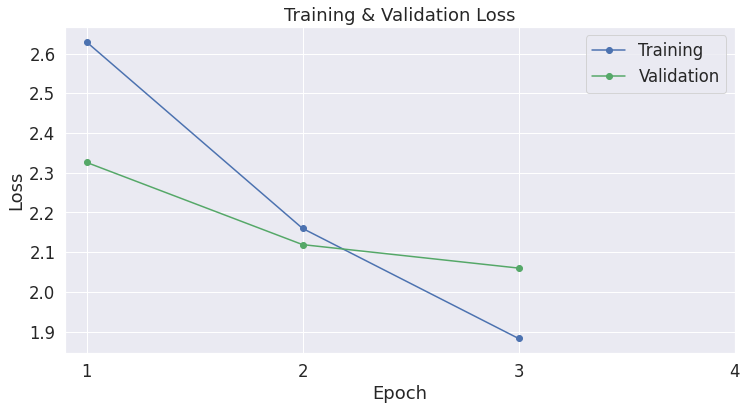

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('precision', 2)
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [ ]:
import os

output_dir = '/content/gpt2-fa-poetry'
os.makedirs(output_dir, exist_ok=True)

model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)
configuration.save_pretrained(output_dir)
!cp /content/gpt2/tokenizer.json /content/gpt2-fa-poetry/

In [ ]:
import re


def generator(model, poet, max_length=128, num_return_sequences=3):
    model.eval()
    prompt = f"<s>{poet}<|startoftext|>"
    print(prompt)

    generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
    generated = generated.to(device)

    decoded_outputs = model.generate(
        generated,
        do_sample=True,
        top_k=50,
        max_length=max_length,
        top_p=0.95,
        num_return_sequences=num_return_sequences
    )


    outputs = []
    for i, output in enumerate(decoded_outputs):
        o = tokenizer.decode(output, skip_special_tokens=False)
        o = o.replace("<s>", "").replace("</s>", "")
        outputs.append(o)



    display.display(display.HTML("""
    <style>
    @import url("https://cdn.jsdelivr.net/gh/rastikerdar/vazir-font@v27.1.0/dist/font-face.css");

    table.xxx {
        margin-right: 15px;
        font-size: 14px;
        direction: rtl !important;
        width: 100%;
        display: flex;
    }
    table.xxx td {
        min-width: 300px !important;
        direction: rtl !important;
        text-align: right !important;
        font-family: "Vazir" !important;
    }
    </style>
    """.strip()))


    df = pd.DataFrame(outputs, columns=["generated"])
    df["generated"] = df["generated"].apply(lambda t: re.sub("\n+", "\n", t.replace("<sep>", "\n")))
    df["generated"] = df["generated"].apply(lambda t: "<p>" + t.replace("\n", "<br/>").replace("<|startoftext|>", "<br/>").strip() + "</p>")


    setup = {
        'border': 2,
        'show_dimensions': True,
        'escape': False,
        'justify': 'right',
        'classes': 'xxx'
    }
    display.display(display.HTML(df.to_html(**setup)))

In [ ]:
print("\n".join(poets))

رودکی
فردوسی
کسایی
ناصرخسرو
منوچهری
فرخی سیستانی
مسعود سعد سلمان
ابوسعید ابوالخیر
باباطاهر
فخرالدین اسعد گرگانی
اسدی توسی
هجویری
خیام
نظامی
عطار
سنایی
خاقانی
انوری
عبدالواسع جبلی
نصرالله منشی
مهستی گنجوی
باباافضل کاشانی
مولوی
سعدی
خواجوی کرمانی
عراقی
سیف فرغانی
حافظ
اوحدی
شیخ محمود شبستری
عبید زاکانی
امیرخسرو دهلوی
سلمان ساوجی
شاه نعمت‌الله ولی
جامی
هلالی جغتایی
وحشی
محتشم کاشانی
شیخ بهایی
عرفی
رضی‌الدین آرتیمانی
صائب تبریزی
فیض کاشانی
بیدل دهلوی
هاتف اصفهانی
فروغی بسطامی
قاآنی
ملا هادی سبزواری
پروین اعتصامی
ملک‌الشعرای بهار
شهریار
رهی معیری
اقبال لاهوری
خلیل‌الله خلیلی
شاطرعباس صبوحی
نیما یوشیج ( آوای آزاد )
احمد شاملو
سهراب سپهری
فروغ فرخزاد
سیمین بهبهانی
مهدی اخوان ثالث
محمدحسن بارق شفیعی
شیون فومنی
کامبیز صدیقی کسمایی
بهرام سالکی
عبدالقهّار عاصی
اِ لیـــار    (جبار محمدی )


## Test pretrained model loaded from "HooshvareLab/gpt2-fa-poetry":

In [ ]:
## load pretrained mdoel from huggingface
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("HooshvareLab/gpt2-fa-poetry")
pretrained_model = AutoModelForCausalLM.from_pretrained("HooshvareLab/gpt2-fa-poetry")
pretrained_model.to('cuda')

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(42001, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=42001, bias=False)
)

In [ ]:
generator(pretrained_model, 'حافظ', num_return_sequences=2)

<s>حافظ<|startoftext|>


,generated
0,حافظای دل مکن از غصه که او یار منستدل شد گرفتار تو و دلدار منستبگذار ای طبیب که بیمار منستدل نیست جز آن غمزه که بیمار منستگوئی که صبر گوشه‌ای از من بگیرکانجا که عشق بر سر بازار منستسرها به باد رفت و من از دست رفت دلیارب چه کار در سر دستار منستمشنو ز من که از می و معشوق مست استمستقبلانه عشق که بسیار منستبا آن که در دل و سینه دارم امید نیستاین در وصال بود و در یار
1,حافظیاد باد آنروز که از چشم تو ما را گله بودیمحال است که در صومعه با دلق تناسخ بودیمبا غیر خدا گفتم و ما را بطلبیدندمی‌خواست که این یار هم از خویش بود هم از خدا همگفتم نتوان گفت که از کوی خرابات درآمدگفت از نظرم غیر خدا هیچ مپرسیددل گفت بدارم به در صومعه با خود گفتمگفت از کرم شاه به خلوتگه شهنشاهحافظ ز برای سخن آمد همه را گفتتا آن که در میخانه دم از صدق زد و داداز دست و دلش توبه شکن بود و می و جامگفتم


In [ ]:
generator(pretrained_model, 'شهریار', num_return_sequences=2)

<s>شهریار<|startoftext|>


,generated
0,شهریارشب از من برد و غم از دل نبرد غمگسار ماشب از من برد و دل از جان نبرد غمگسار ماچو لاله از دل خونین فروچکید اشک و بازغزل آمد به گوش گل صدای سار ماز آه سینه سوز سینه سوز ما گذشتز دود سینه دم سرد روزگار مابه کام دل ز مژگان جگر خراش دمیدچو آه گرم از دل بی تاب شهریار ماسپهر ما به سرگشتگی و چشم اشکباربه سوی آسمان چارده رفت و چارماغبار غم به دامان کوه غم نشستغبار غم به دامان کوه غم نشست
1,شهریارهر که از جور تو بی بهره نه مرد سفرستیارب این دیده که گریان شده شبگیر درستگرنه تنها به تو ای تازه گل باغ حیاتگل سوری چرا بر رخ یاران به درستبا غم عشق تو یک عمر چه باشد گرمیمکاروان همه شب ناله زار و جگرستگر چه عمری به سر کوی تو می آیم بازچشم گریان ز پی همرهی باد سحرستگر چه در سینه من عشق تو بی سوز بودآه من باد کز او ناله نی هم جگرستدر گذر از دو سه روزی که به بازار وجودهر دو بازار وجود از


In [ ]:
 generator(pretrained_model, 'سهراب سپهری', num_return_sequences=2)

<s>سهراب سپهری<|startoftext|>


,generated
0,سهراب سپهریدر گل و من ، ای نسیم سرد و باران ، ای نسیم روشن!ای بهار سبز! در این سبز میدان ، ای بهار شبنم!ای نسیم سرد، ای اشک گرمم ! ای نهال گل ، از این نسیم سوزان ، بگذراز میان گل و شبنم ، به سوی من نگاه کنای نسیم صبح ، ای آب ، ای شبنم! ای شبنم! ای شبنم! ای شبنم! ای شبنم! ای شبنم!من چه دارم ؟ یا چه دارم ؟ ای شبنم!ای نسیم گل! این شبنم ، ای شبنم! ای شبنم! ای شبنم! ای شبنم!
1,سهراب سپهریدر باغ ، و دیوار من ، دیوار من ، دیوار من ، در آب ، و دود چراغ من ، و دود چراغ من ، بر در می شکند .به چشم خودم ، در خواب ، و در رگ های خواب ، و صدا می شکند .در هر جنبشی این رنگ ، و در هر تار ، و در هر پرده ، صدایی می نشیند.می جوشد ، و می ریزد ، و می ریزد ، و می چسبد ، و در وزش زمزمه ، و در هیچ ، و در هر تپش این بوی، گل می بندد ، و می ریزد ، و می
